# Table of contents
1. [Requirements](#Requirements)
2. [Introduction](#Introduction)
3. [Imports](#Imports)
    1. [Libraries](#Libraries)
    2. [Data](#Data)
4. [Data Exploration](#data-exploration)
5. [Modelling](#modelling)
    1. [Baseline](#baseline)
    2. [LSTM](#lstm)
6. [Results Analysis](#results-analysis)

# Requirements

In [7]:
! pip install tensorboard

In [8]:
!pip install keras-tuner

In [9]:
!pip install --upgrade holidays

## Introduction

## Imports

### Libraries


In [10]:
import sympy
import pandas as pd
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
import numpy as np
import kerastuner as kt
from kerastuner.engine.hyperparameters import HyperParameters
from datetime import datetime

In [11]:
import matplotlib.pyplot as plt
import holidays
import seaborn as sns
from keras.layers import LSTM, Bidirectional, Dense
from google.colab import drive 
import keras
from tensorflow.keras import callbacks, layers, losses, metrics, optimizers

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import tensorboard

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/NOVA IMS/IMS Deep Neural Networks/DLNN Project'

/content/drive/MyDrive/NOVA IMS/IMS Deep Neural Networks/DLNN Project


### Data

In [ ]:
# Load the data
worksheet_EnergyConsumption = pd.read_csv('/content/drive/MyDrive/NOVA IMS/IMS Deep Neural Networks/DLNN Project/consumption.csv')
worksheet_Weather = pd.read_csv('/content/drive/MyDrive/NOVA IMS/IMS Deep Neural Networks/DLNN Project/weather.csv')

In [ ]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table


In [ ]:
missing_zero_values_table(worksheet_EnergyConsumption)

Your selected dataframe has 8 columns and 43823 Rows.
There are 6 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
PT_wind_generation_actual,0,43823,100.0,43823,100.0,float64
PT_wind_offshore_generation_actual,0,43823,100.0,43823,100.0,float64
PT_solar_generation_actual,20263,8,0.0,20271,46.3,float64
PT_load_actual_entsoe_transparency,0,1,0.0,1,0.0,float64
PT_load_forecast_entsoe_transparency,0,1,0.0,1,0.0,float64
PT_wind_onshore_generation_actual,0,1,0.0,1,0.0,float64


In [ ]:
missing_zero_values_table(worksheet_Weather)

Your selected dataframe has 4 columns and 43823 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [ ]:
# Transform timestamp datatype
worksheet_EnergyConsumption["utc_timestamp"] = pd.to_datetime(worksheet_EnergyConsumption["utc_timestamp"])
worksheet_Weather["utc_timestamp"] = pd.to_datetime(worksheet_Weather["utc_timestamp"])

# As seguintes colunas estão todas NaN, não são uteis. The remaining columns are removed since they aren't usefull.
worksheet_EnergyConsumption.drop([
    "cet_cest_timestamp",
    "PT_wind_generation_actual",
    "PT_wind_offshore_generation_actual",
    "PT_wind_onshore_generation_actual",
    "PT_solar_generation_actual",
    "PT_load_forecast_entsoe_transparency"
], axis=1, inplace=True)

# Bfill 
#worksheet_EnergyConsumption["PT_load_forecast_entsoe_transparency"] = worksheet_EnergyConsumption["PT_load_forecast_entsoe_transparency"].bfill()
worksheet_EnergyConsumption["PT_load_actual_entsoe_transparency"] = worksheet_EnergyConsumption["PT_load_actual_entsoe_transparency"].bfill()


In [ ]:
#pt_holidays=holidays.country_holidays('PT')
#worksheet_EnergyConsumption['isHoliday']=pd.Series(worksheet_EnergyConsumption.index).apply(lambda x: holidays.country_holidays('PT').get(x)).values.astype('bool').astype('int')

In [ ]:
df=pd.merge(worksheet_EnergyConsumption, worksheet_Weather, on="utc_timestamp")

In [ ]:
# Timestamps are very usefull as inputs for modelling purposes, especially when using time series.
# If there is peridiocity within the physical phenomena which generates the feature we're measuring, then to use the "timestamp" we must transform the data into a "readable format" for the model, not this string-like form.
# Therefore, we can transform this timeperiod into a "signal" - the sine and cosine transforms. This signal, represented by sin and cosin waves will "emulate" the "time of the day" and "of the year" as usable signals/data.
# Being weather and energy consumption data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.
date_time=worksheet_EnergyConsumption["utc_timestamp"].copy()
timestamp_s=date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


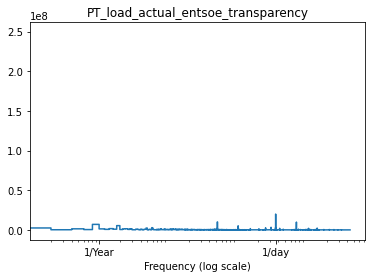

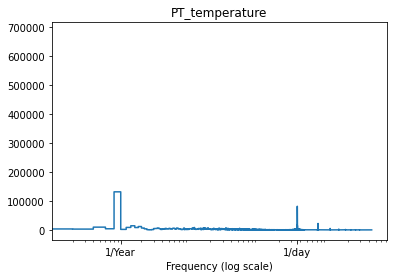

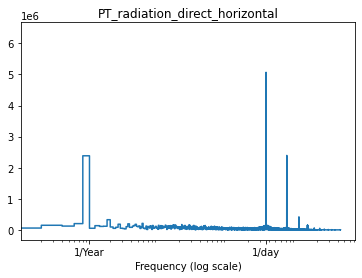

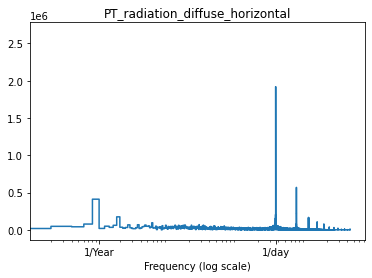

In [ ]:
# para confirmar a periocidade diária e anual através da FFT: (Transformada de Fourier - explicar um pouco o que é?)
# COMMENT: After a carefull look at the results we can clearly observe and confirm our assumptions: 
# both yearly and daily periodiocity exist. However, a intra-daily peridiocity also is highlighted in the graphs,
# especially in the features which concern radiation. This intra-day is explained by the "solar cycle", the time of the day.  
def plot_fft(df):
    columns=df.columns
    for col in columns:
        values=df[col].values
        fft=np.fft.fft(values)
        fft = tf.signal.rfft(df[col])
        f_per_dataset = np.arange(0, len(fft))

        n_samples_h = len(df[col])
        hours_per_year = 24*365.2524
        years_per_dataset = n_samples_h/(hours_per_year)

        f_per_year = f_per_dataset/years_per_dataset
        plt.figure()
        plt.step(f_per_year, np.abs(fft))
        plt.xscale('log')
        
        plt.xlim([0.1, max(plt.xlim())])
        plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
        _ = plt.xlabel('Frequency (log scale)')
        plt.title(col)

    plt.show()
df_copy=df.loc[:,["PT_load_actual_entsoe_transparency","PT_temperature","PT_radiation_direct_horizontal","PT_radiation_diffuse_horizontal"]]
plot_fft(df_copy)

In [ ]:
df=df.set_index('utc_timestamp')

In [ ]:
num_features=len(df.columns)

In [ ]:
# Splitting the data -
# slicing the data for
# - Training : [2015-2017]
# - Test: [2018]
# - Validation [2019]
# COMMENTS: 
# Em timeseries forecasting pode-se fazer é testar os modelos com splits diferentes, para fazer cross validation dos datasets utilizados. Caso contrário podemos cair no erro de seleccionar o melhor modelo, randomly, para o split que fizemos apenas.

df_train=df.loc['2015':'2017'].copy()
df_test=df.loc['2018'].copy()
df_validation=df.loc['2019'].copy()


In [ ]:
# Normalize the data
# The normalization should not consider the time-series/features within the test and validation sets. 
# Hence, "the mean and standard deviation should only be computed using the training data 
# so that the models have no access to the values in the validation and test sets."
# ref- https://www.tensorflow.org/tutorials/structured_data/time_series
train_mean = df_train.mean()
train_std = df_train.std()

train_df = (df_train - train_mean) / train_std
val_df = (df_validation - train_mean) / train_std
test_df = (df_test - train_mean) / train_std

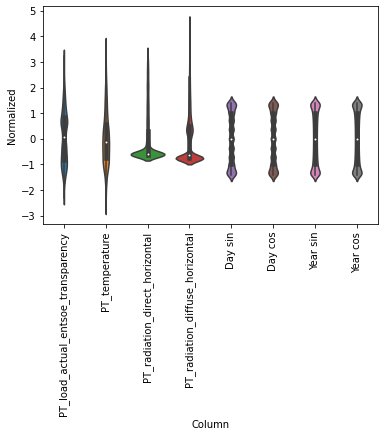

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure()
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)


In [6]:
from statsmodels.tsa.stattools import adfuller

for col in df.columns:
  # Perform the ADF test on the column
    result = adfuller(df[col])
    # Print the test statistic and p-value
    print(f"Test statistic for {col}: {result[0]}")
    print(f"p-value for {col}: {result[1]}")

    # Interpret the results
    if result[1] < 0.05:
        print(f"{col} is stationary")
    else:
        print(f"{col} is non-stationary")
# Perform the ADF test on the time series
#result = adfuller(df['PT_load_actual_entsoe_transparency'])
#result = adfuller(df['PT_temperature'])

# Print the test statistic and the p-value
# print(f"Test statistic: {result[0]}")
# print(f"p-value: {result[1]}")

# # Interpret the results
# if result[1] < 0.05:
#     print("The time series is stationary")
# else:
#     print("The time series is non-stationary")

NameError: name 'df' is not defined

## Data Exploration

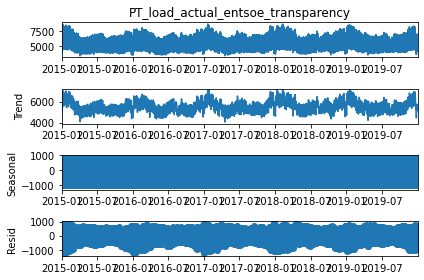

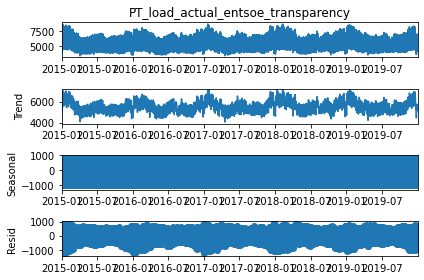

In [ ]:
# Para tentar "completar" esta secção podemos fazer uns plots bónitos dos perfis de consumo e temperatura e radiação
# Podemos também decompor estas em perfis sazonais, diários, semanais, mensais, etc.
# AKA Timeseries decomposition através da statsmodel
# - Seasonal
# - Autocorrelation function (acf)
# - Partial Autocorrelation function (PACF)
# refs & exemplos - https://neptune.ai/blog/select-model-for-time-series-prediction-task

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['PT_load_actual_entsoe_transparency'])
result.plot()

In [ ]:
# # Necessitamos de ver se os dados são, ou não, estacionários.
# "it is highly necessary to check if the data is stationary. In time series forecasting, we cannot derive valuable insights from data if it is stationary."
# https://www.geeksforgeeks.org/how-to-check-if-time-series-data-is-stationary-with-python/
# https://machinelearningmastery.com/time-series-data-stationary-python/

## Modelling

Metrics to use:
- RMSE
- MSE
- MAE
- MAPE
- r2 (?)
        
ref- https://analyticsindiamag.com/a-guide-to-different-evaluation-metrics-for-time-series-forecasting-models/

In [26]:
# Set the input_sequence_length length - this is the "window" timeframe used to make a single prediction
input_sequence_length = 24
# The output sequence length is the number of steps that the neural network predicts
output_sequence_length = 24

# Index for the forecasted variable - energy consumption
index_target = df_train.columns.get_loc("PT_load_actual_entsoe_transparency")


In [27]:
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data.iloc[i-input_sequence_length:i,:])
        y.append(data.iloc[i:i + output_sequence_length, index_target]) 
    
    # Convert the x and y to numpy arrays
    x = np.array(x).astype(float)
    y = np.array(y).astype(float)
    return x, y


In [28]:
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_df)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_df)
x_validation,y_validation= partition_dataset(input_sequence_length, output_sequence_length, val_df)

In [ ]:
# def sliding_window(data, window_size, forecast_horizon):
#     # Initialize a list to store the input and output sequences
#     input_sequences = []
#     output_sequences = []

#     # Iterate over the data and create the input and output sequences
#     for i in range(len(data) - window_size - forecast_horizon + 1):
#         input_sequences.append(data[i:i + window_size])
#         output_sequences.append(data[i + window_size:i + window_size + forecast_horizon])

#     return input_sequences, output_sequences

In [ ]:
# # Set the window size to 24 and the forecast horizon to 24
# window_size = 24
# forecast_horizon = 24
# # Create the input and output sequences using the sliding window function
# train_input_sequences, train_output_sequences = sliding_window(df_train, window_size, forecast_horizon)

### Baseline
        Persistence

A persistência é o método de baseline mais condiserado e que, como o nome indica, considera que o valor para o futuro é igual à ultima observação. Pode ser denotado pela seguinte equação:

$ T_{t+1} = T_{t} $ 

In [29]:
# Baseline model - persistence/naive forecast (of last observation):
y_pred_persistence=np.zeros((y_train.shape),dtype=float)
for i in range(len(y_pred_persistence)):
    y_pred_persistence[i,:]=x_train[i,-1][0]
#aux. variable for plot
x_copy=np.zeros((y_train.shape),dtype=float)
for r in range(x_train.shape[0]):
    for c in range((x_train.shape[1])):
        x_copy[r,c]=x_train[r,c,0]


In [30]:
# x-axis aux. vectors
x_input=np.arange(0,24)
x_ahead=np.arange(24,48)

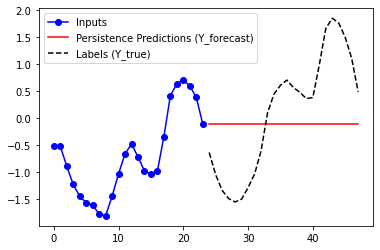

In [31]:
plt.figure()
plt.plot()
plt.plot(x_input,x_copy[0],color='blue', label='Inputs',marker='o')
plt.plot(x_ahead,y_pred_persistence[0], color='red', label = 'Persistence Predictions (Y_forecast)')
plt.plot(x_ahead,y_train[0],color='black',label='Labels (Y_true)',linestyle='dashed')
plt.legend()

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error



MSE_Persistence=mean_squared_error(y_true=y_train,y_pred=y_pred_persistence)
RMSE_Persistence=mean_squared_error(y_true=y_train,y_pred=y_pred_persistence,squared=True)
MAPE_Persistence=mean_absolute_percentage_error(y_true=y_train,y_pred=y_pred_persistence)
MAE_Persistence=mean_absolute_error(y_true=y_train,y_pred=y_pred_persistence)

### Simple RNN

In [1]:
# Create a TensorBoard callback
import os

working_dir=os.getcwd()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir = os.path.join(working_dir, 'logs'))
# Define the model

def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.SimpleRNN(units=hp.Int('units', min_value=32, max_value=256, step=32),
                                   input_shape=(None, num_features)))
  model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
                loss='mean_squared_error',
                metrics=['mean_absolute_error','mse', 'mape'])
  return model

# Create a tuner
tuner = kt.Hyperband(build_model,
                     objective='mean_absolute_error',
                     max_epochs=100,
                     factor=3,
                     seed=1,hyperband_iterations=100,)

# Search for the best model
tuner.search(x_train, y_train, epochs=100, validation_data=(x_test, y_test),callbacks=[tensorboard_callback])

NameError: name 'keras' is not defined

In [51]:
#%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir='/content/drive/MyDrive/NOVA IMS/IMS Deep Neural Networks/DLNN Project/logs' # Para chamar o callback e poder visualizar no tensorboard. 

Reusing TensorBoard on port 6006 (pid 13129), started 0:00:32 ago. (Use '!kill 13129' to kill it.)

<IPython.core.display.Javascript object>

In [55]:
!kill 13129

In [53]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the validation set
best_model.evaluate(x_validation, y_validation)

273/273 [==============================] - 2s 4ms/step - loss: 0.1345 - mean_absolute_error: 0.2563 - mse: 0.1345 - mape: 171.9669


[0.1344510167837143,
 0.25628453493118286,
 0.1344510167837143,
 171.96685791015625]

### Bi-LSTM

In [ ]:
# Define the model
def build_model(hp):
    model = Sequential()
    lstm_activations=hp.Choice('lstm_activations', values=['relu', 'tanh','sigmoid'])
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32),activation=lstm_activations, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))))
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32),activation=lstm_activations)))

    #model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32),activation=lstm_activations, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    #model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32),return_sequences=True))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    dense_activations=hp.Choice('dense_activations', values=['relu', 'tanh','sigmoid'])
    model.add(Dense(24,activation=dense_activations))
    
    # Choose an optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'sgd','rmsprop'])
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    else:    
        optimizer = tf.keras.optimizers.RMSprop(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
        
    # Compile the model
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(),metrics=['mse', 'mae', 'mape'])
    model.summary
    return model


In [ ]:
import os
#working_dir=os.getcwd()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir = '/content/drive/MyDrive/NOVA IMS/IMS Deep Neural Networks/DLNN Project')

# Define the search space for Keras Tuner
hps = HyperParameters()
#hps.Choice('batch_size', [32, 64, 128, 256])
#hps.Choice('activation', ['relu', 'tanh','sigmoid'])
# Use the Keras Tuner to search for the best set of hyperparameters
tuner = kt.Hyperband(build_model, objective='mse', max_epochs=10,directory=os.path.normpath('C:/'))
tuner.search(x_train, y_train, epochs=100,validation_data=(x_validation, y_validation),callbacks=[tensorboard_callback])


## Results Analysis